<h1>I want to recreate and visually see the degradation problem with neural networks.</h1>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

<h3>There are 5 batches of training data and a test batch, I am using batch 1 as training and batch 2 as testing data for my model </h3>

In [3]:
file1 = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1')
file2 = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2')
meta = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta')

In [4]:
meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

<h3>There are 10 classes of objects in the dataset</h3>

In [5]:
len(file1[b'data'][0])

3072

<h3>Length of each image array is 3072 = 32px * 32px * 3 (RGB) <br>
The documentation of this dataset suggests that the array is in the format
[ R, R, R .... G, G, G .... B, B, B ]</h3>

<h2>Viewing the dataset: </h2>

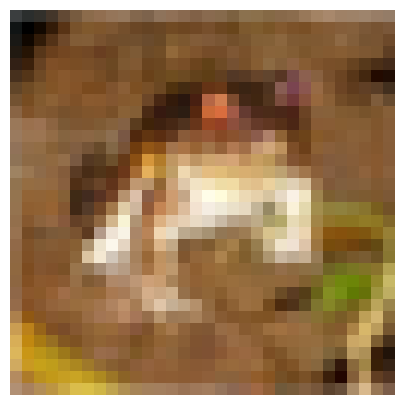

b'frog'

----------------------------



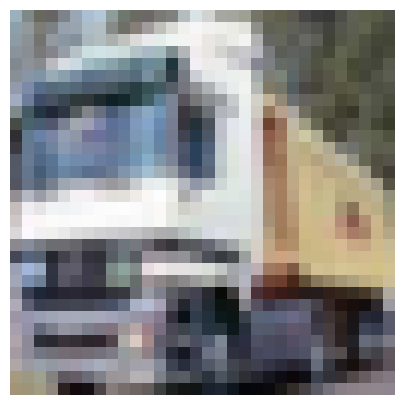

b'truck'

----------------------------



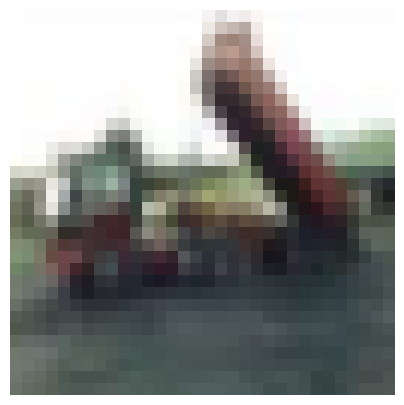

b'truck'

----------------------------



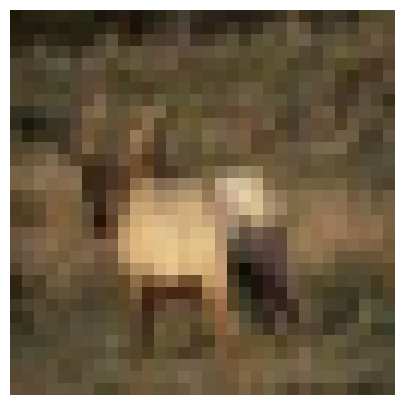

b'deer'

----------------------------



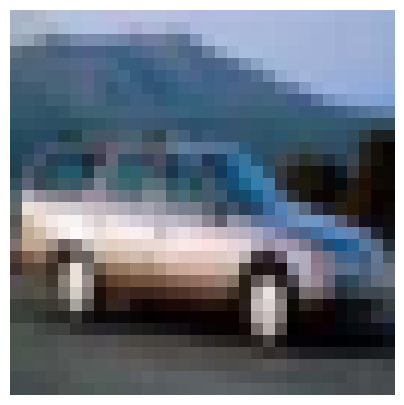

b'automobile'

----------------------------



In [6]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

for i in range (5):
    img_raw = file1[b'data'][i]
    
    # Transformation required since the array is in [R, R, R, G, G, G, B, B, B] format
    img_reshaped = img_raw.reshape(3, 32, 32)
    image_correct_format = np.transpose(img_reshaped, (1, 2, 0))
    img = Image.fromarray(image_correct_format)

    plt.figure(figsize=(5, 5))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()
    
    label = file1[b'labels'][i]
    print(meta[b'label_names'][label])
    print("\n----------------------------\n")

<h2>Creating the Neural Network</h2>

In [7]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<h3>Hyperparameters</h3>

In [8]:
batch_size = 128
learning_rate = 0.001
num_epochs = 20

<h3>Transformations</h3>

In [9]:
from torchvision.transforms import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# --- 1. SETUP AND DATA LOADING ---

# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20 # Increased for a deeper network

# Define transformations for the CIFAR-10 data
# We apply data augmentation to the training set to improve generalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Using device: cuda


<h3>Design the Dataset</h3>

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, transform = False):
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_raw = self.img_list[idx]
        label = self.label_list[idx]
        
        img_reshaped = img_raw.reshape(3, 32, 32)
        image = np.transpose(img_reshaped, (1, 2, 0))
        
        image_pil = Image.fromarray(image)
        image_transformed = image_pil
        
        if self.transform:
            image_transformed = self.transform(image_pil) 
        
        return image_transformed, label

<h3>Designing the CNNs</h3>

Basic Block

In [12]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

32 Layer CNN

In [13]:
class CNN32(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.conv1 = BasicBlock(3, 16)
        self.stage1 = self._make_stage(16, 16, 10)
        self.stage2 = self._make_stage(16, 32, 10)
        self.stage3 = self._make_stage(32, 64, 10)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, downsample = False):
        layers = []

        stride = 2 if downsample else 1
        layers.append(BasicBlock(in_channels, out_channels, stride = stride))

        for _ in range(num_blocks-1):
            layers.append(BasicBlock(out_channels,out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

model1 = CNN32().to(device)
print("Model1 initiated")

Model1 initiated


64 Layer CNN

In [14]:
class CNN64(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv1 = BasicBlock(3, 8) 
        self.conv2 = BasicBlock(8, 16)
        self.stage1 = self._make_stage(16, 16, 20)
        self.stage2 = self._make_stage(16, 32, 20)
        self.stage3 = self._make_stage(32, 64, 20) 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, downsample=False):
        layers = []

        stride = 2 if downsample else 1
        layers.append(BasicBlock(in_channels, out_channels, stride=stride))
        
        for _ in range(num_blocks - 1):
            layers.append(BasicBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model2 = CNN64().to(device)
print("Model2 created")

Model2 created


In [15]:
train_dataset = CustomDataset(img_list = file1[b'data'], label_list = file1[b'labels'], transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = CustomDataset(img_list = file2[b'data'], label_list = file2[b'labels'], transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

In [16]:
model = model1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
acc32 = []

print("\nStarting Training...")

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        acc32.append(accuracy)
        print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

print("Finished Training")


Starting Training...
Epoch [1/20], Loss: 2.0416
Test Accuracy after Epoch 1: 17.01%
Epoch [2/20], Loss: 1.8399
Test Accuracy after Epoch 2: 25.12%
Epoch [3/20], Loss: 1.7571
Test Accuracy after Epoch 3: 27.94%
Epoch [4/20], Loss: 1.6930
Test Accuracy after Epoch 4: 34.84%
Epoch [5/20], Loss: 1.6483
Test Accuracy after Epoch 5: 35.86%
Epoch [6/20], Loss: 1.5882
Test Accuracy after Epoch 6: 32.17%
Epoch [7/20], Loss: 1.5386
Test Accuracy after Epoch 7: 36.28%
Epoch [8/20], Loss: 1.5021
Test Accuracy after Epoch 8: 37.30%
Epoch [9/20], Loss: 1.4625
Test Accuracy after Epoch 9: 37.32%
Epoch [10/20], Loss: 1.4325
Test Accuracy after Epoch 10: 43.24%
Epoch [11/20], Loss: 1.3965
Test Accuracy after Epoch 11: 39.72%
Epoch [12/20], Loss: 1.3865
Test Accuracy after Epoch 12: 38.11%
Epoch [13/20], Loss: 1.3323
Test Accuracy after Epoch 13: 39.90%
Epoch [14/20], Loss: 1.2942
Test Accuracy after Epoch 14: 42.63%
Epoch [15/20], Loss: 1.2718
Test Accuracy after Epoch 15: 47.66%
Epoch [16/20], Loss: 

In [17]:
model = model2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
acc64 = []

print("\nStarting Training...")

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        acc64.append(accuracy)
        print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

print("Finished Training")


Starting Training...
Epoch [1/20], Loss: 2.1715
Test Accuracy after Epoch 1: 15.53%
Epoch [2/20], Loss: 2.0491
Test Accuracy after Epoch 2: 15.59%
Epoch [3/20], Loss: 1.9674
Test Accuracy after Epoch 3: 18.02%
Epoch [4/20], Loss: 1.9382
Test Accuracy after Epoch 4: 24.36%
Epoch [5/20], Loss: 1.8952
Test Accuracy after Epoch 5: 20.93%
Epoch [6/20], Loss: 1.8685
Test Accuracy after Epoch 6: 24.60%
Epoch [7/20], Loss: 1.8461
Test Accuracy after Epoch 7: 29.61%
Epoch [8/20], Loss: 1.8084
Test Accuracy after Epoch 8: 27.45%
Epoch [9/20], Loss: 1.8115
Test Accuracy after Epoch 9: 22.90%
Epoch [10/20], Loss: 1.9084
Test Accuracy after Epoch 10: 13.57%
Epoch [11/20], Loss: 2.0115
Test Accuracy after Epoch 11: 22.36%
Epoch [12/20], Loss: 1.9564
Test Accuracy after Epoch 12: 21.58%
Epoch [13/20], Loss: 1.9086
Test Accuracy after Epoch 13: 25.73%
Epoch [14/20], Loss: 1.9226
Test Accuracy after Epoch 14: 26.34%
Epoch [15/20], Loss: 1.8788
Test Accuracy after Epoch 15: 27.54%
Epoch [16/20], Loss: 

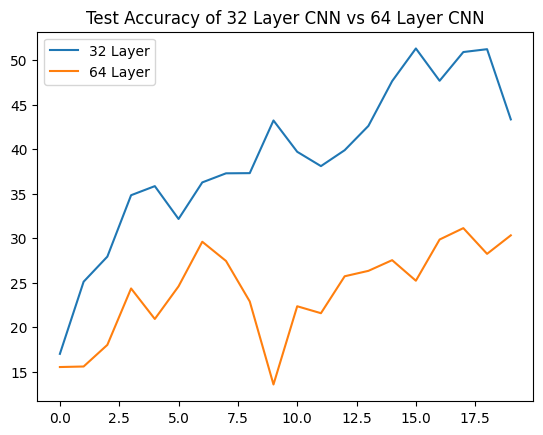

In [25]:
plt.plot(acc32)
plt.plot(acc64)
plt.title("Test Accuracy of 32 Layer CNN vs 64 Layer CNN")
plt.legend(["32 Layer", "64 Layer"])